# Cholesky Decomposition/Factorization

Given a symmetric positive definite matrix A, the Cholesky decomposition is an upper triangular matrix U (with strictly positive diagonal entries) such that:

$A=U^TU$

In [1]:
import pycompss.interactive as ipycompss

In [2]:
# Start PyCOMPSs runtime with graph and tracing enabled
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(graph=True, trace=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=True, monitor=1000, trace=True)

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           ______         ______   *
*         :         )         |____  \       |____  \  *
*   .~ ~ -.\       /.- ~~ .      __) |          __) |  *
*   >       `.   .'       <     |__  |         |__  |  *
*  (         .- -.         )   ____) |   _    ____) |  *
*   `- -.-~  `- -'  ~-.- -'   |______/  |_|  |______/  *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

 

* - Log path : /home/javier/.COMPSs/Interactive_05/
* - PyCOMPSs Runtime started... Have fun!              *
********************************************************


* - Log path : /home/user/.COMPSs/Interactive_18/
* - PyCOMPSs Runtime started... Have fun!              *
********************************************************


In [3]:
from pycompss.api.task import task
from scipy import linalg
import numpy as np
import ctypes

### Task definitions

In [4]:
@task(returns=list)
def createBlock(BSIZE, MKLProc, diag):
    import os
    os.environ["MKL_NUM_THREADS"]=str(MKLProc)
    block = np.array(np.random.random((BSIZE, BSIZE)), dtype=np.double,copy=False)
    mb = np.matrix(block, dtype=np.double, copy=False)
    mb = mb + np.transpose(mb)
    if diag:
        mb = mb + 2*BSIZE*np.eye(BSIZE)
    return mb

@task(returns=np.ndarray)
def potrf(A, MKLProc):
    from scipy.linalg.lapack import dpotrf
    import os
    os.environ['MKL_NUM_THREADS']=str(MKLProc)
    A = dpotrf(A, lower=True)[0]
    return A

@task(returns=np.ndarray)
def solve_triangular(A, B, MKLProc):
    from scipy.linalg import solve_triangular
    from numpy import transpose
    import os
    os.environ['MKL_NUM_THREADS']=str(MKLProc)
    B = transpose(B)
    B = solve_triangular(A, B, lower=True)  # , trans='T'
    B = transpose(B)
    return B

@task(returns=np.ndarray)
def gemm(alpha, A, B, C, beta, MKLProc):
    from scipy.linalg.blas import dgemm
    from numpy import transpose
    import os
    os.environ['MKL_NUM_THREADS']=str(MKLProc)
    B = transpose(B)
    C = dgemm(alpha, A, B, c=C, beta=beta)
    return C

### Auxiliary functions

In [5]:
def genMatrix(MSIZE, BSIZE, MKLProc, A):
    for i in range(MSIZE):
        A.append([])
        for j in range(MSIZE):
            A[i].append([])
    for i in range(MSIZE):
        mb = createBlock(BSIZE, MKLProc, True)
        A[i][i]=mb
        for j in range(i+1,MSIZE):
            mb = createBlock(BSIZE, MKLProc, False)
            A[i][j]=mb
            A[j][i]=mb

In [6]:
def cholesky_blocked(MSIZE, BSIZE, mkl_threads, A):
    import os
    for k in range(MSIZE):
        # Diagonal block factorization
        A[k][k] = potrf(A[k][k], mkl_threads)
        # Triangular systems
        for i in range(k+1, MSIZE):
            A[i][k] = solve_triangular(A[k][k], A[i][k], mkl_threads)
            A[k][i] = np.zeros((BSIZE,BSIZE))
        # update trailing matrix
        for i in range(k+1, MSIZE):
            for j in range(i, MSIZE):
                A[j][i] = gemm(-1.0, A[j][k], A[i][k], A[j][i], 1.0, mkl_threads)
    return A

## MAIN Code

Parameters (that can be configured in the following cell):
* MSIZE: Matrix size (default: 4)
* BSIZE: Block size (default: 128)
* mkl_threads: Number of MKL threads (default: 1)

In [7]:
import ipywidgets as widgets
from pycompss.api.api import compss_barrier
import time

w_MSIZE = widgets.IntText(value=4)
w_BSIZE = widgets.IntText(value=128)
w_mkl_threads = widgets.IntText(value=1)

def cholesky(MSIZE, BSIZE, mkl_threads):
    # Generate de matrix
    startTime = time.time()

    # Generate supermatrix
    A = []
    res = []
    genMatrix(MSIZE, BSIZE, mkl_threads, A)
    compss_barrier()

    initTime = time.time() - startTime
    startDecompTime = time.time()
    res = cholesky_blocked(MSIZE, BSIZE, mkl_threads, A)
    compss_barrier()

    decompTime = time.time() - startDecompTime
    totalTime = decompTime + initTime
    
    print("---------- Elapsed Times ----------")
    print("initT:{}".format(initTime))
    print("decompT:{}".format(decompTime))
    print("totalTime:{}".format(totalTime))
    print("-----------------------------------")
    
widgets.interact_manual(cholesky, MSIZE=w_MSIZE, BSIZE=w_BSIZE, mkl_threads=w_mkl_threads)

interactive(children=(IntText(value=4, description='MSIZE'), IntText(value=128, description='BSIZE'), IntText(…

<function __main__.cholesky(MSIZE, BSIZE, mkl_threads)>

In [8]:
ipycompss.stop()

********************************************************
***************** STOPPING PyCOMPSs ********************
********************************************************
Checking if any issue happened.
         have not been brought to the master.
********************************************************


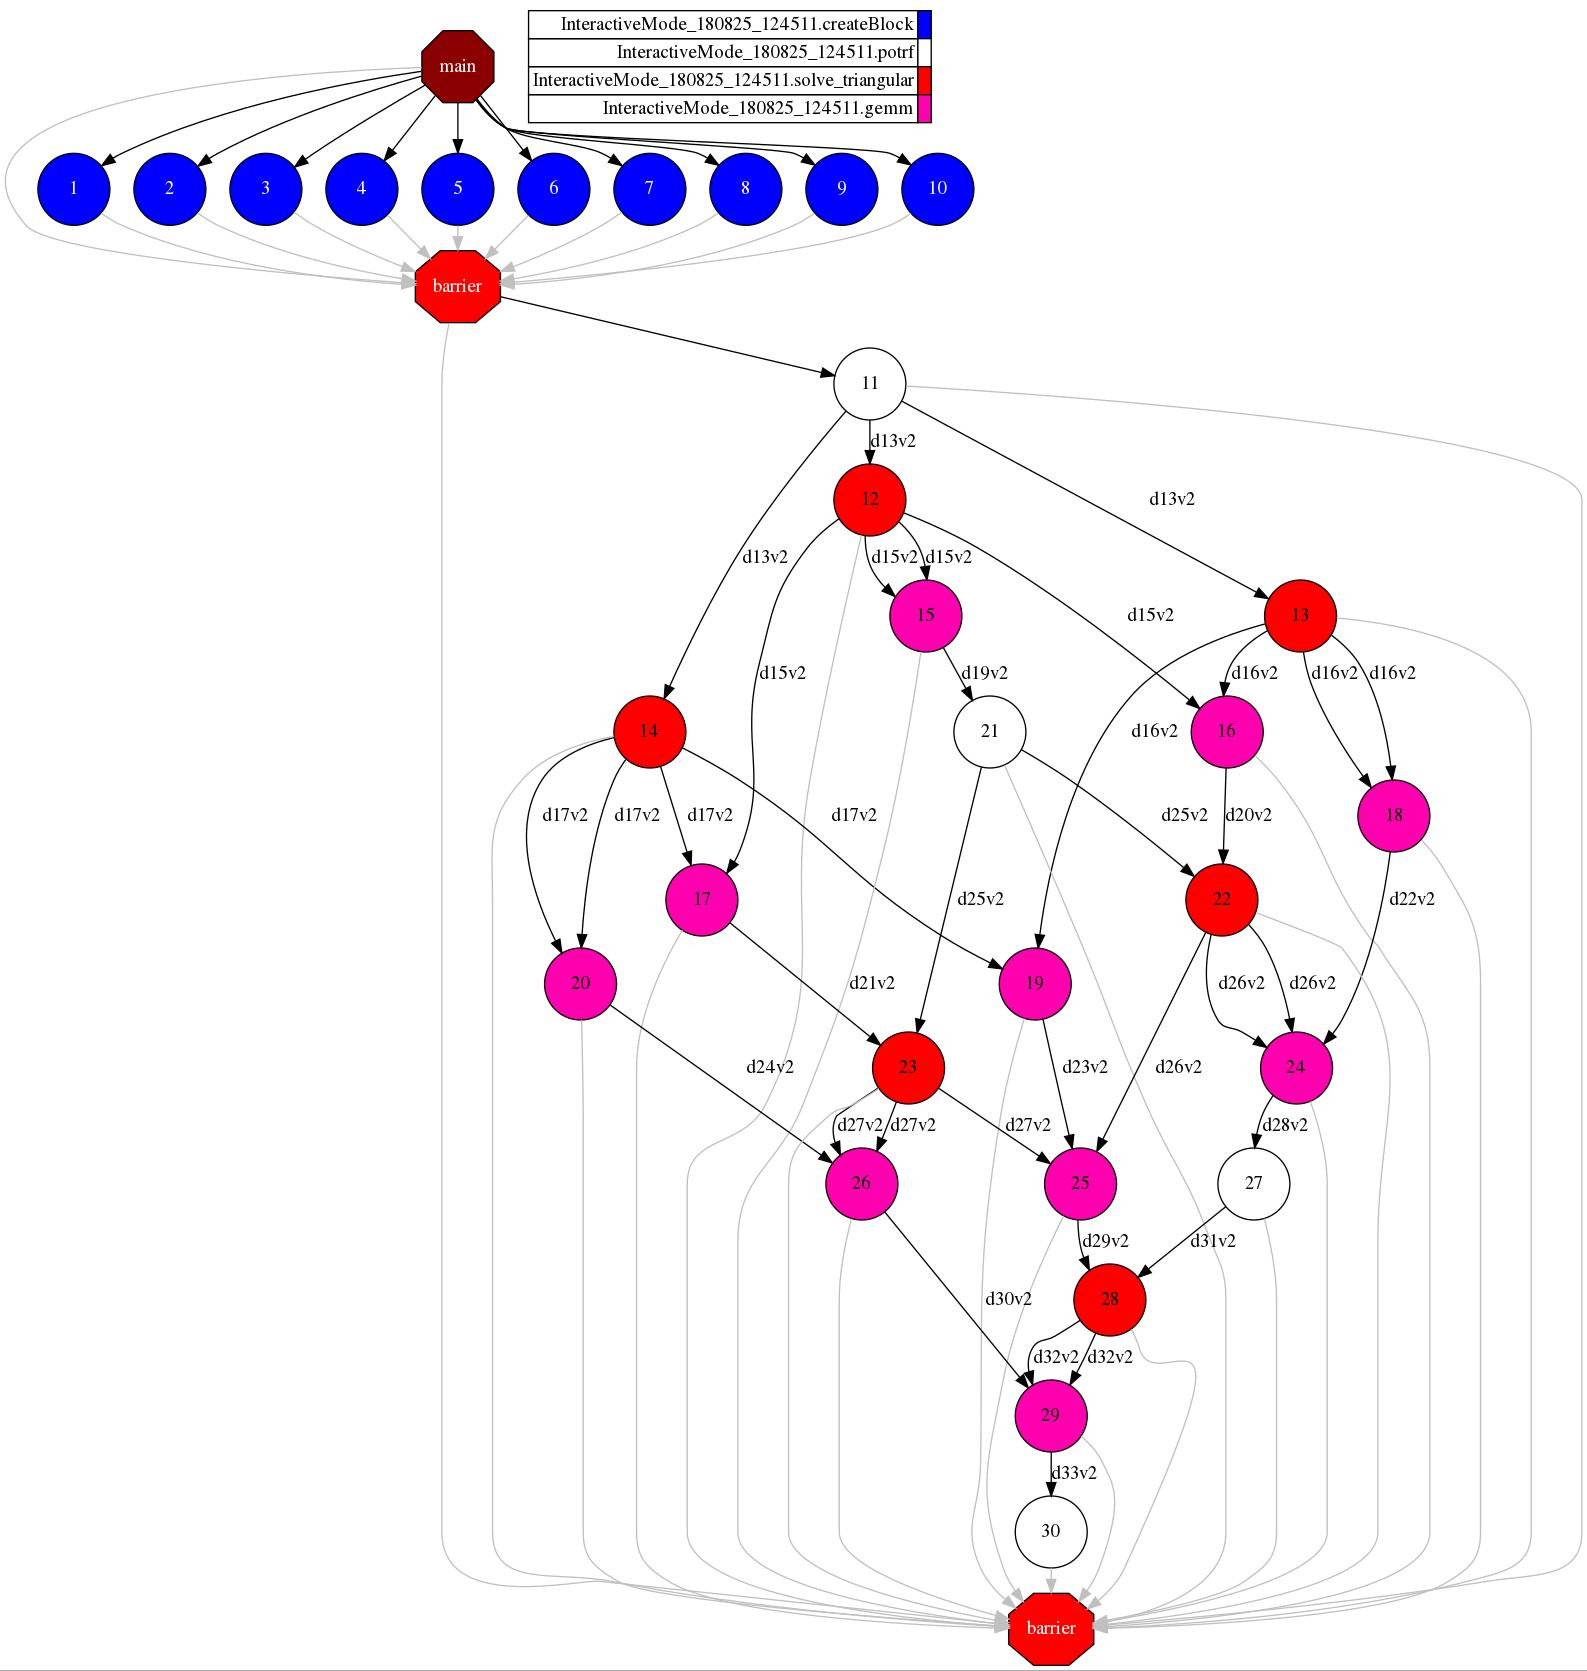

In [9]:
ipycompss.complete_task_graph(fit=True)